In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=1
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr
from copy import deepcopy


In [2]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)
database = f"/home/jeon/MissingSat/database"
LG = pklload(f"{database}/00_LocalGroup_final.pickle")

[Output 01026] Age (Gyr) : 11.624 / 13.741, z = 0.17149 (a = 0.8536)


In [3]:
subs = None
for key in LG.keys():
    tmp = LG[key]['subs']
    subs = tmp if(subs is None) else np.hstack((subs, tmp))

In [4]:
print( subs.dtype.names )

('nparts', 'id', 'timestep', 'level', 'host', 'hostsub', 'nbsub', 'nextsub', 'aexp', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Lx', 'Ly', 'Lz', 'r', 'a', 'b', 'c', 'ek', 'ep', 'et', 'spin', 'sigma', 'rvir', 'mvir', 'tvir', 'cvel', 'rho0', 'rc', 'mcontam', 'r10_mem', 'r50_mem', 'r90_mem', 'r10_vir', 'r50_vir', 'r90_vir', 'r10_max', 'r50_max', 'r90_max', 'sub', 'dink', 'mdm', 'mstar', 'mcold', 'mcell', 'Host')


In [5]:
hascold = subs['mcold'] <= 1e3
isdink = subs['dink']

  2%|▏         | 49/3226 [00:00<00:13, 238.07it/s]

  3%|▎         | 97/3226 [00:00<00:13, 232.20it/s]/tmp/ipykernel_6269/925149474.py:15: RuntimeWarning: divide by zero encountered in log10
  vmax = np.max([np.log10(iarr['mstar']), np.log10(iarr['mcell']), np.log10(iarr['mcold'])])
/tmp/ipykernel_6269/925149474.py:16: RuntimeWarning: divide by zero encountered in log10
  vmin = np.min([np.log10(iarr['mstar']), np.log10(iarr['mcell']), np.log10(iarr['mcold'])])
100%|██████████| 3226/3226 [00:38<00:00, 82.84it/s] 


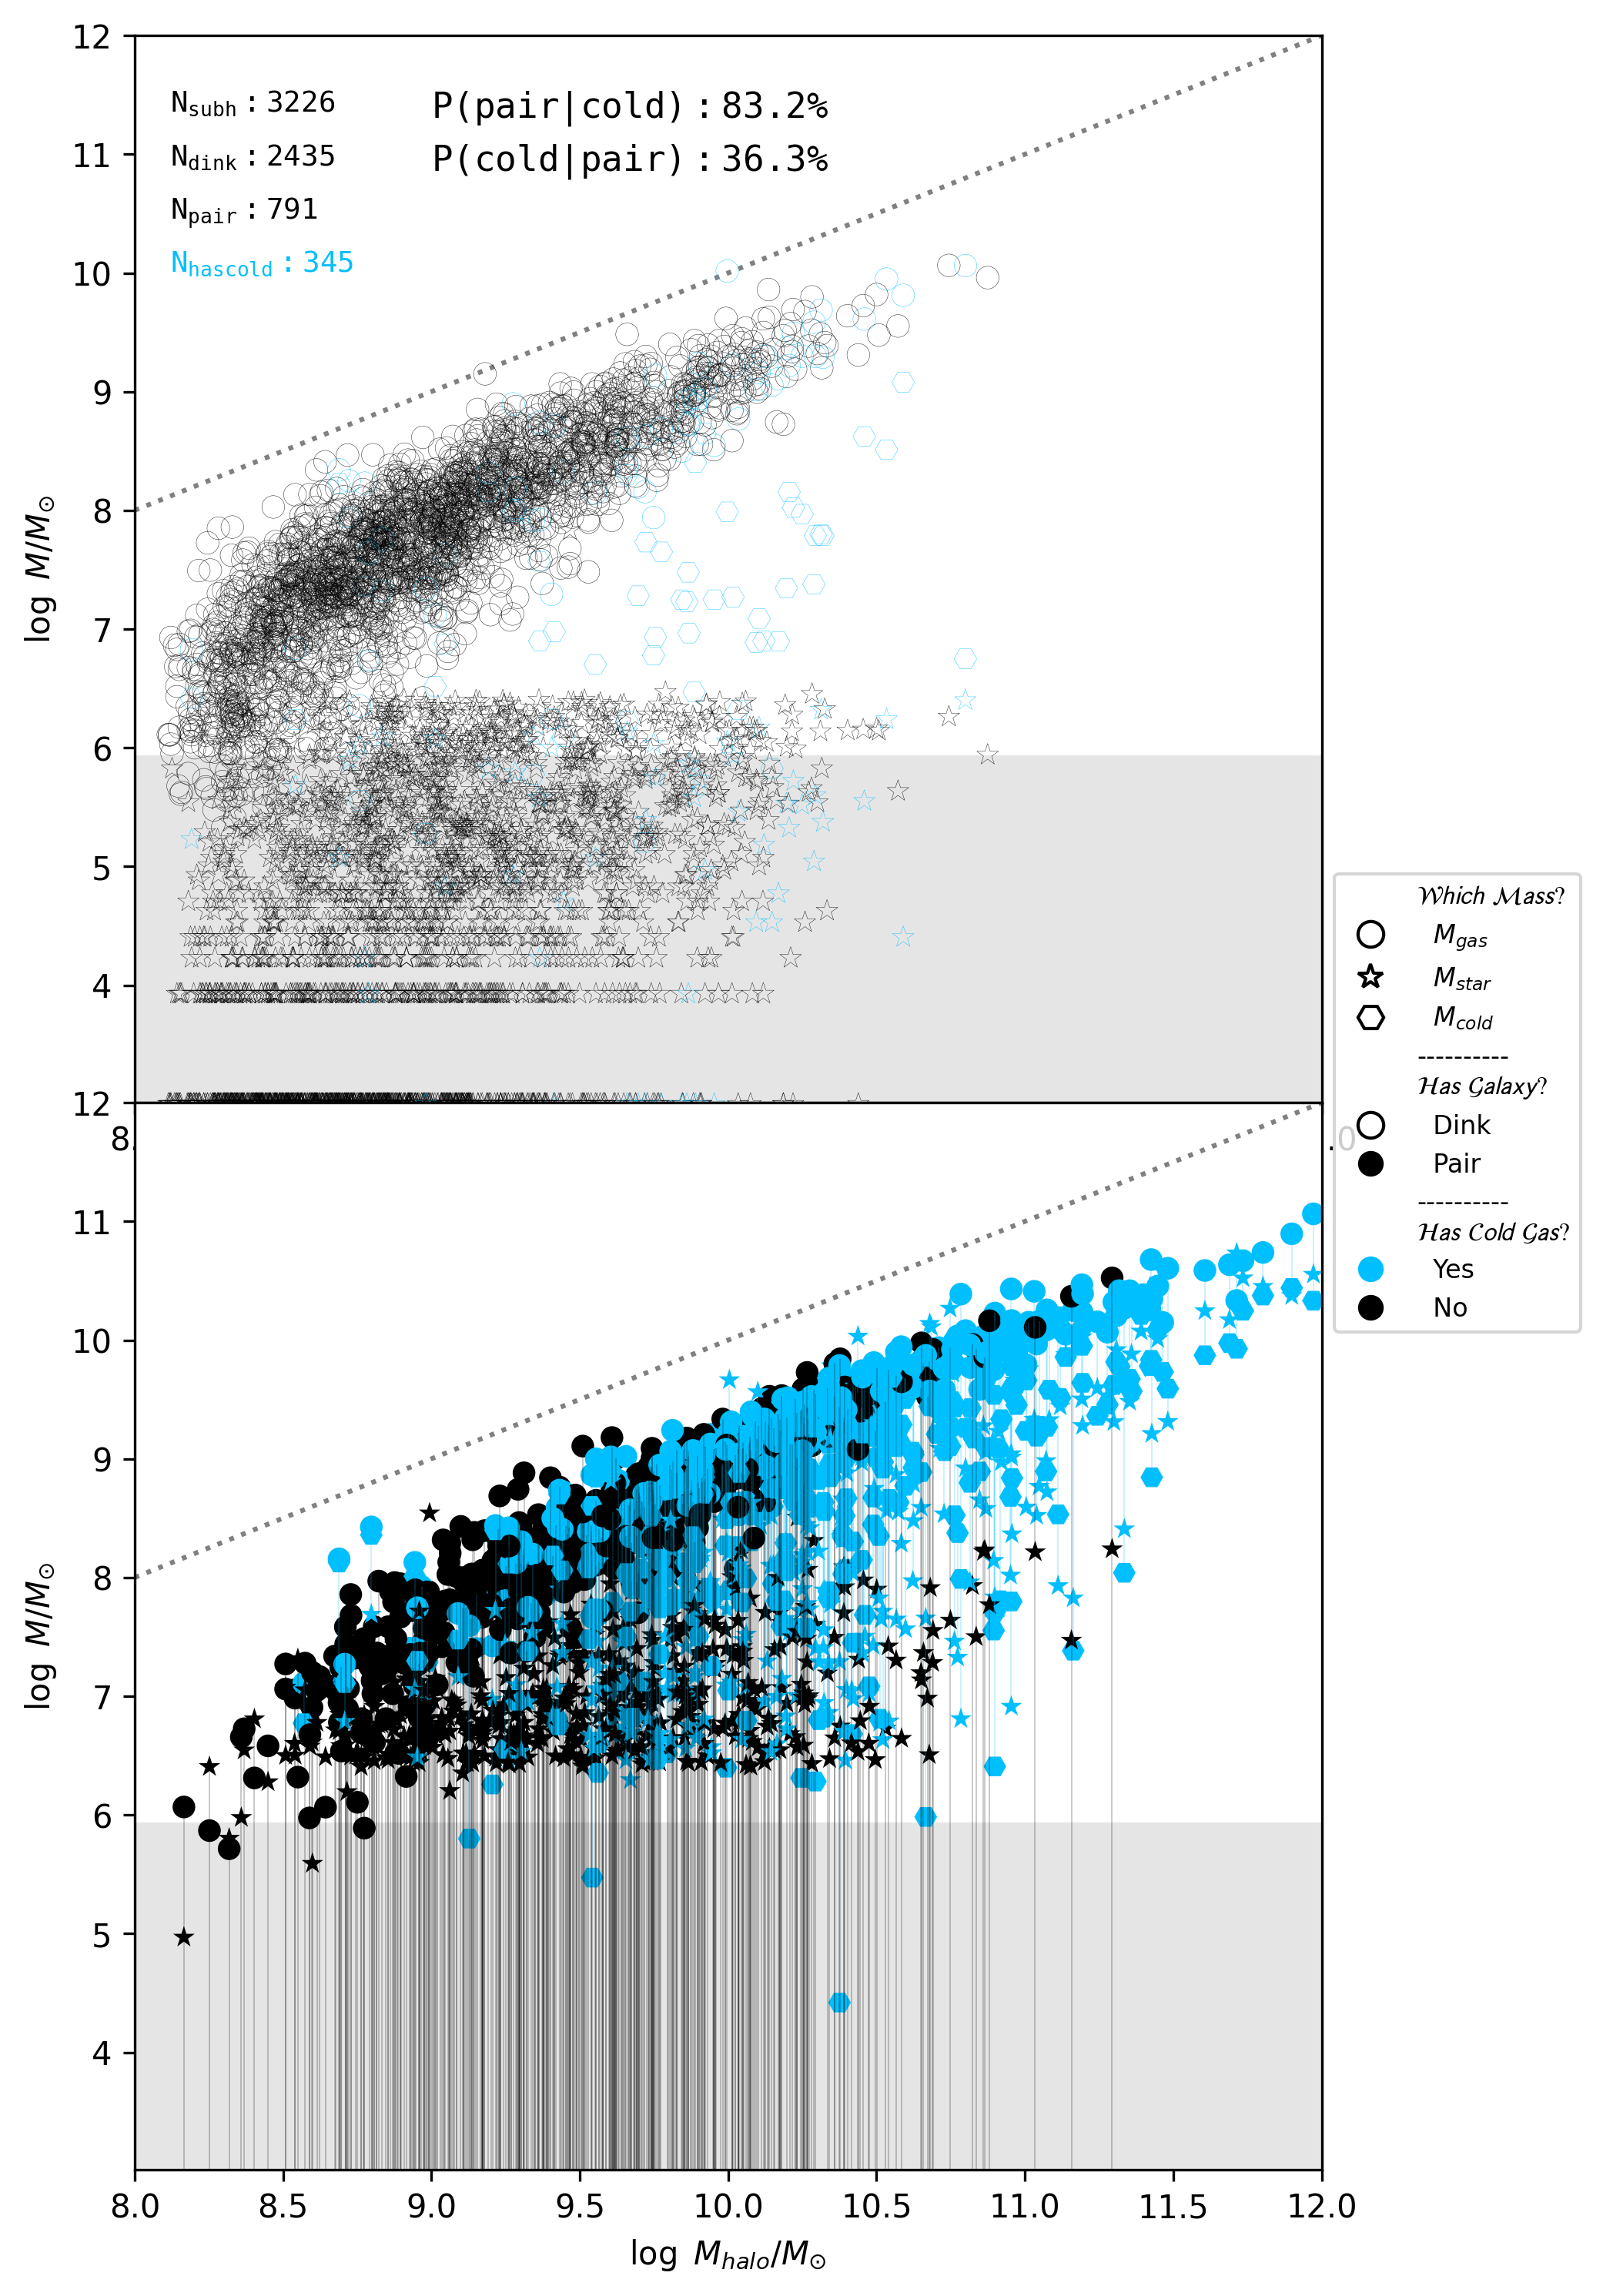

In [6]:
fig, axes = plt.subplots(nrows=2, dpi=300, figsize=(8,12))
for iarr in tqdm(subs):
    isdink = iarr['dink']
    color = 'k' if(iarr['mcold']<=1e3) else 'deepskyblue'
    facecolor='none' if(isdink) else color
    edgecolor=color if(isdink) else 'none'
    linecolor=color
    lw = 0.1 if(isdink) else 0.3
    ax = axes[0] if(isdink) else axes[1]

    ax.scatter(np.log10(iarr['mdm']), np.log10(iarr['mstar']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=0.1, marker='*')
    if(iarr['mcold']>1e3): ax.scatter(np.log10(iarr['mdm']), np.log10(iarr['mcold']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=0.1, marker='H')
    ax.scatter(np.log10(iarr['mdm']), np.log10(iarr['mcell']), facecolor=facecolor, edgecolor=edgecolor, s=50, lw=0.1)
    if(not isdink):
        vmax = np.max([np.log10(iarr['mstar']), np.log10(iarr['mcell']), np.log10(iarr['mcold'])])
        vmin = np.min([np.log10(iarr['mstar']), np.log10(iarr['mcell']), np.log10(iarr['mcold'])])
        ax.plot([np.log10(iarr['mdm']),np.log10(iarr['mdm'])], [vmin, vmax], color=linecolor, lw=0.1)

for ax in axes.flatten():
    ax.fill_between([7.9,12.1],3, np.log10(np.min(gals['m'])), ec='none', fc='grey', alpha=0.2, zorder=-1)

    ax.set_xlim(8,12)
    xlim = ax.get_xlim()
    ax.plot(xlim, xlim, ls=':', color='grey', zorder=-1)
    ax.set_ylim(3.01,12)
    ax.set_ylabel(r"$\log\ M/M_{\odot}$")
ax.set_xlabel(r"$\log\ M_{halo}/M_{\odot}$")

hascold = subs['mcold'] > 1e3
haspair = ~subs['dink']
dinks = subs[subs['dink']]
pairs = subs[~subs['dink']]
ax = axes[0]
ax.text(0.03, 0.95, fr"$\mathtt{{ N_{{subh}}: {len(subs)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.03, 0.90, fr"$\mathtt{{ N_{{dink}}: {len(dinks)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.03, 0.85, fr"$\mathtt{{ N_{{pair}}: {len(pairs)} }}$", ha='left', va='top', color='k', fontsize=9, transform=ax.transAxes)
ax.text(0.03, 0.80, fr"$\mathtt{{ N_{{has cold}}: {np.sum(hascold)} }}$", ha='left', va='top', color='deepskyblue', fontsize=9, transform=ax.transAxes)
ax.text(0.25, 0.95, fr"$\mathtt{{ P(pair|cold): {100*np.sum(haspair&hascold)/np.sum(hascold):.1f}\% }}$", ha='left', va='top', color='k', fontsize=11, transform=ax.transAxes)
ax.text(0.25, 0.90, fr"$\mathtt{{ P(cold|pair): {100*np.sum(haspair&hascold)/np.sum(haspair):.1f}\% }}$", ha='left', va='top', color='k', fontsize=11, transform=ax.transAxes)

# Making Legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label=r'$\mathcal{Which\ Mass?}$'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{gas}$'),
    Line2D([0],[0], marker='*',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{star}$'),
    Line2D([0],[0], marker='H',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label=r'  $M_{cold}$'),
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label="----------\n"+r'$\mathcal{Has\ Galaxy?}$'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='k', markerfacecolor='none', markersize=8, label='  Dink'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='none', markerfacecolor='k', markersize=8, label='  Pair'),
    Line2D([0],[0], marker='.',color='none', markeredgecolor='k', markerfacecolor='none', markersize=0, label="----------\n"+r'$\mathcal{Has\ Cold\ Gas?}$'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='none', markerfacecolor='deepskyblue', markersize=8, label='  Yes'),
    Line2D([0],[0], marker='o',color='none', markeredgecolor='none', markerfacecolor='k', markersize=8, label='  No'),
]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0), fontsize=8)
axes[0].set_aspect(1/2.5)
axes[1].set_aspect(1/2.5)
plt.subplots_adjust(hspace=0)
# fig.savefig(f"./database/photo/01_compare_pairs/NH_all_mratio.png", dpi=400, facecolor='white', bbox_inches='tight')
# print(f"`./database/photo/01_compare_pairs/NH_all_mratio.png` save done")
plt.show()
plt.close()

In [8]:
subs.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('mcontam', '<f8'), ('r10_mem', '<f8'), ('r50_mem', '<f8'), ('r90_mem', '<f8'), ('r10_vir', '<f8'), ('r50_vir', '<f8'), ('r90_vir', '<f8'), ('r10_max', '<f8'), ('r50_max', '<f8'), ('r90_max', '<f8'), ('sub', '<i8'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8'), ('Host', '<i4')])

# Do they have different 

In [42]:
dinks = subs[subs['dink']]
dink_colds = dinks[dinks['mcold'] > 1e3]; gdink_colds = dink_colds[dink_colds['mcontam']/dink_colds['m'] < 0.1]
dink_poors = dinks[dinks['mcold'] <= 1e3]; gdink_poors = dink_poors[dink_poors['mcontam']/dink_poors['m'] < 0.1]
pairs = subs[~subs['dink']]
pair_colds = pairs[pairs['mcold'] > 1e3]; gpair_colds = pair_colds[pair_colds['mcontam']/pair_colds['m'] < 0.1]
pair_poors = pairs[pairs['mcold'] <= 1e3]; gpair_poors = pair_poors[pair_poors['mcontam']/pair_poors['m'] < 0.1]

## Masses?

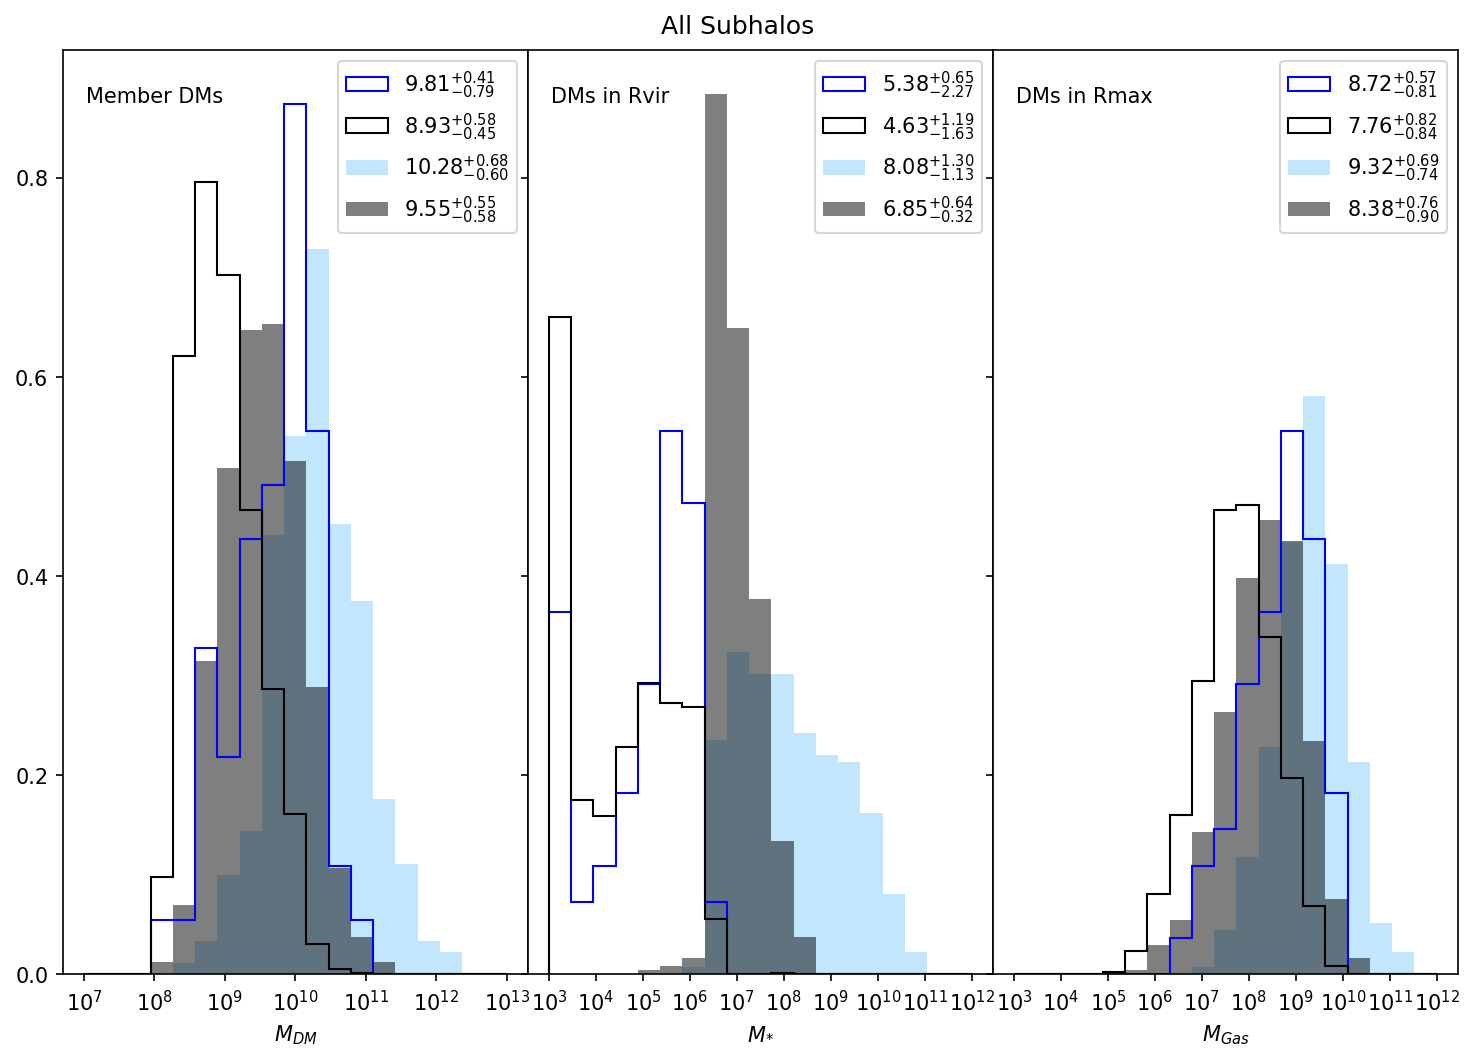

In [133]:
# Mass
fig, axes = plt.subplots(1,3, figsize=(12,8), dpi=150, sharey=True)


pops = [dink_colds, dink_poors, pair_colds, pair_poors]
colors = ['blue', 'k', 'lightskyblue', 'k']
alphas = [1, 1, 0.5, 0.5]
histtypes = ['step', 'step', 'bar', 'bar']
fills = [False, False, True, True]
names = ["w/o Gal\nw/ Cold","w/o Gal\nw/o Cold","w/ Gal\nw/ Cold","w/ Gal\nw/o Cold"]

ax = axes[0]
tick1 = 7; tick2 = 13
bins = np.linspace(tick1, tick2, 20)
ticks = np.arange(tick1, tick2+1, 1)
ticklabels = [fr"$10^{{{i}}}$" for i in ticks]
for i in range(4):
    prop = pops[i]['mdm']; prop=np.log10(prop)
    qs = np.percentile(prop, [16,50,84])
    ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.text(0.05, 0.95, "Member DMs", ha='left', va='center', transform=ax.transAxes)
ax.set_xlabel(r"$M_{DM}$")
ax.legend()

ax = axes[1]
tick1 = 3; tick2 = 12
bins = np.linspace(tick1, tick2, 20)
ticks = np.arange(tick1, tick2+1, 1)
ticklabels = [fr"$10^{{{i}}}$" for i in ticks]
for i in range(4):
    prop = pops[i]['mstar']; prop=np.log10(prop)
    qs = np.percentile(prop, [16,50,84])
    ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.text(0.05, 0.95, "DMs in Rvir", ha='left', va='center', transform=ax.transAxes)
ax.set_xlabel(r"$M_{*}$")
ax.legend()

ax = axes[2]
tick1 = 3; tick2 = 12
bins = np.linspace(tick1, tick2, 20)
ticks = np.arange(tick1, tick2+1, 1)
ticklabels = [fr"$10^{{{i}}}$" for i in ticks]
for i in range(4):
    prop = pops[i]['mcell']; prop=np.log10(prop)
    qs = np.percentile(prop, [16,50,84])
    ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.text(0.05, 0.95, "DMs in Rmax", ha='left', va='center', transform=ax.transAxes)
ax.set_xlabel(r"$M_{Gas}$")
ax.legend()

plt.subplots_adjust(wspace=0)
plt.suptitle("All Subhalos", y=0.91)
plt.show()

## Concentration?

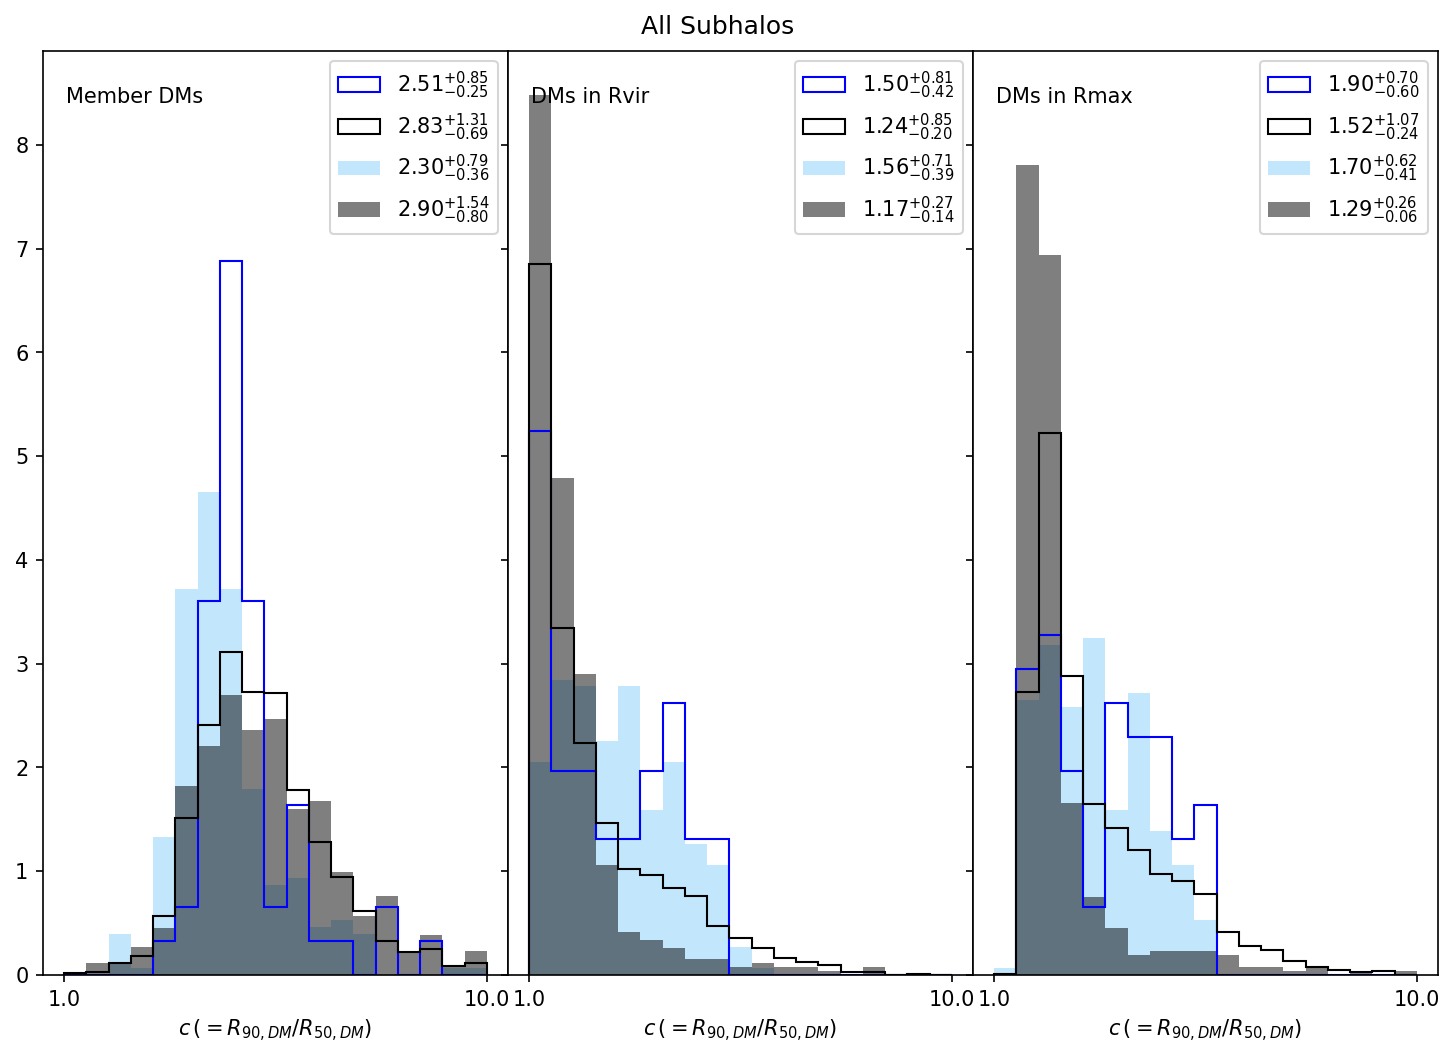

In [112]:
# Mass
fig, axes = plt.subplots(1,3, figsize=(12,8), dpi=150, sharey=True)
tick1 = 0; tick2 = 1
bins = np.linspace(tick1, tick2, 20)
ticks = np.arange(tick1, tick2+1, 1)
ticklabels = [f"{10.**i}" for i in ticks]

pops = [dink_colds, dink_poors, pair_colds, pair_poors]
colors = ['blue', 'k', 'lightskyblue', 'k']
alphas = [1, 1, 0.5, 0.5]
histtypes = ['step', 'step', 'bar', 'bar']
fills = [False, False, True, True]
names = ["w/o Gal\nw/ Cold","w/o Gal\nw/o Cold","w/ Gal\nw/ Cold","w/ Gal\nw/o Cold"]

ax = axes[0]
for i in range(4):
    prop = pops[i]['r90_mem'] / pops[i]['r50_mem']; prop=np.log10(prop)
    qs = 10**np.percentile(prop, [16,50,84])
    ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.text(0.05, 0.95, "Member DMs", ha='left', va='center', transform=ax.transAxes)
ax.set_xlabel(r"$c\,(=R_{90,DM}/R_{50,DM})$")
ax.legend()

ax = axes[1]
for i in range(4):
    prop = pops[i]['r90_vir'] / pops[i]['r50_vir']; prop=np.log10(prop)
    qs = 10**np.percentile(prop, [16,50,84])
    ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.text(0.05, 0.95, "DMs in Rvir", ha='left', va='center', transform=ax.transAxes)
ax.set_xlabel(r"$c\,(=R_{90,DM}/R_{50,DM})$")
ax.legend()

ax = axes[2]
for i in range(4):
    prop = pops[i]['r90_max'] / pops[i]['r50_max']; prop=np.log10(prop)
    qs = 10**np.percentile(prop, [16,50,84])
    ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.text(0.05, 0.95, "DMs in Rmax", ha='left', va='center', transform=ax.transAxes)
ax.set_xlabel(r"$c\,(=R_{90,DM}/R_{50,DM})$")
ax.legend()

plt.subplots_adjust(wspace=0)
plt.suptitle("All Subhalos", y=0.91)
plt.show()

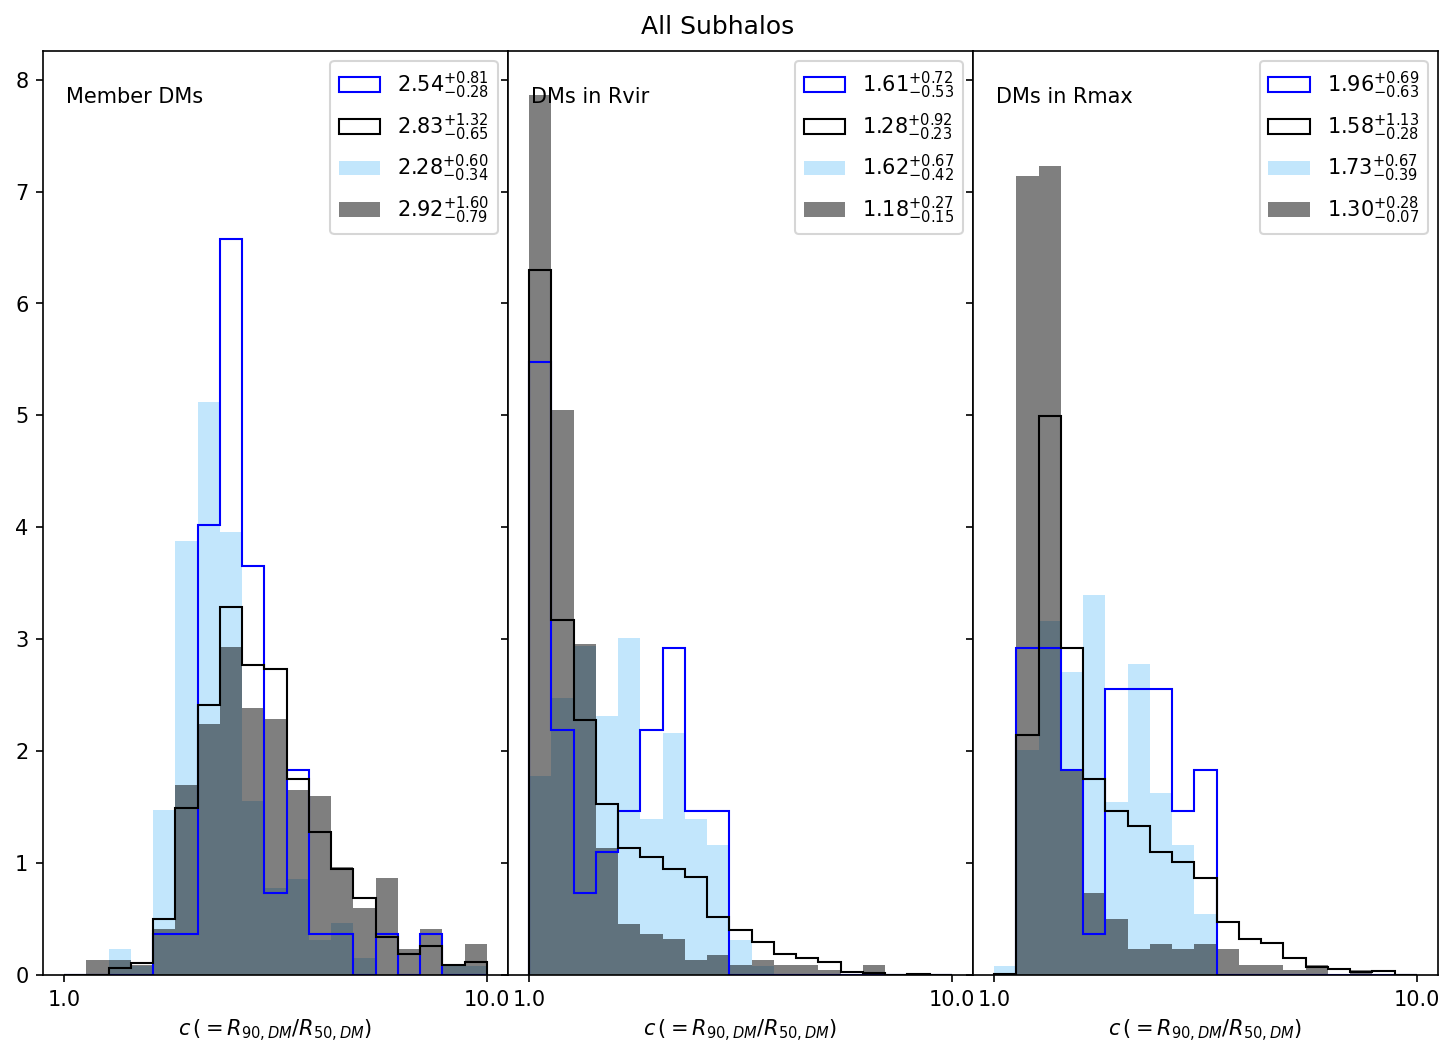

In [113]:
# Mass
fig, axes = plt.subplots(1,3, figsize=(12,8), dpi=150, sharey=True)
tick1 = 0; tick2 = 1
bins = np.linspace(tick1, tick2, 20)
ticks = np.arange(tick1, tick2+1, 1)
ticklabels = [f"{10.**i}" for i in ticks]

pops = [gdink_colds, gdink_poors, gpair_colds, gpair_poors]
colors = ['blue', 'k', 'lightskyblue', 'k']
alphas = [1, 1, 0.5, 0.5]
histtypes = ['step', 'step', 'bar', 'bar']
fills = [False, False, True, True]
names = ["w/o Gal\nw/ Cold","w/o Gal\nw/o Cold","w/ Gal\nw/ Cold","w/ Gal\nw/o Cold"]

ax = axes[0]
for i in range(4):
    prop = pops[i]['r90_mem'] / pops[i]['r50_mem']; prop=np.log10(prop)
    qs = 10**np.percentile(prop, [16,50,84])
    ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.text(0.05, 0.95, "Member DMs", ha='left', va='center', transform=ax.transAxes)
ax.set_xlabel(r"$c\,(=R_{90,DM}/R_{50,DM})$")
ax.legend()

ax = axes[1]
for i in range(4):
    prop = pops[i]['r90_vir'] / pops[i]['r50_vir']; prop=np.log10(prop)
    qs = 10**np.percentile(prop, [16,50,84])
    ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.text(0.05, 0.95, "DMs in Rvir", ha='left', va='center', transform=ax.transAxes)
ax.set_xlabel(r"$c\,(=R_{90,DM}/R_{50,DM})$")
ax.legend()

ax = axes[2]
for i in range(4):
    prop = pops[i]['r90_max'] / pops[i]['r50_max']; prop=np.log10(prop)
    qs = 10**np.percentile(prop, [16,50,84])
    ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.text(0.05, 0.95, "DMs in Rmax", ha='left', va='center', transform=ax.transAxes)
ax.set_xlabel(r"$c\,(=R_{90,DM}/R_{50,DM})$")
ax.legend()

plt.subplots_adjust(wspace=0)
plt.suptitle("All Subhalos", y=0.91)
plt.show()

## Contamination?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


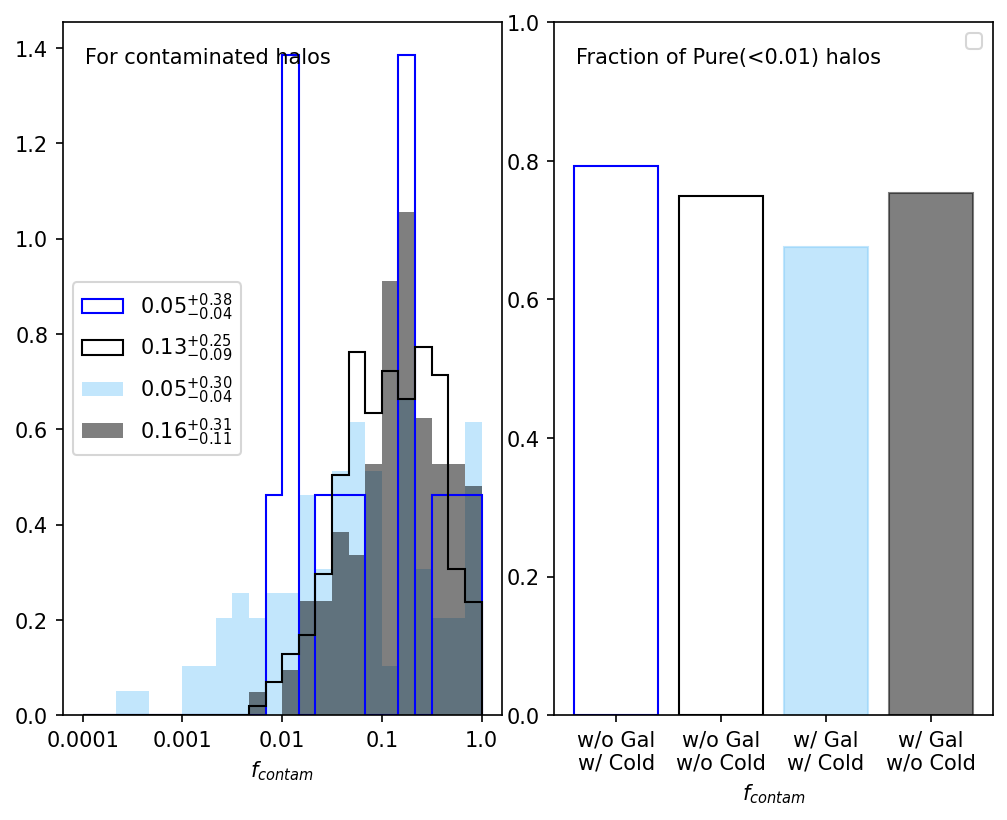

In [117]:
# Mass
fig, axes = plt.subplots(1,2, figsize=(8,6), dpi=150)
tick1 = -4; tick2 = 0
bins = np.linspace(tick1, tick2, 25)
ticks = np.arange(tick1, tick2+1, 1)
ticklabels = [f"{10.**i}" for i in ticks]
# bins = np.logspace(-4, 0, 20)

pops = [dink_colds, dink_poors, pair_colds, pair_poors]
colors = ['blue', 'k', 'lightskyblue', 'k']
alphas = [1, 1, 0.5, 0.5]
histtypes = ['step', 'step', 'bar', 'bar']
fills = [False, False, True, True]
names = ["w/o Gal\nw/ Cold","w/o Gal\nw/o Cold","w/ Gal\nw/ Cold","w/ Gal\nw/o Cold"]

ax = axes[0]
for i in range(4):
    prop = pops[i]['mcontam'] / pops[i]['m']
    prop = prop[prop>0]; prop=np.log10(prop)
    qs = 10**np.percentile(prop, [16,50,84])
    ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.text(0.05, 0.95, "For contaminated halos", ha='left', va='center', transform=ax.transAxes)
ax.set_xlabel(r"$f_{contam}$")
ax.legend(loc='center left')

ax = axes[1]
for i in range(4):
    tmp = pops[i]['mcontam'] / pops[i]['m']
    val = np.sum(tmp<0.01)/len(tmp)
    ax.bar(i,val, fc=colors[i], ec=colors[i], fill=fills[i], alpha=alphas[i])
    # ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
# ax.set_xscale('log')
ax.set_ylim(0,1)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(names)
ax.text(0.05, 0.95, "Fraction of Pure(<0.01) halos", ha='left', va='center', transform=ax.transAxes)
ax.legend()


plt.subplots_adjust(wspace=0.12)
plt.show()

## Cold Gas?

In [121]:
tmp.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('mcontam', '<f8'), ('r10_mem', '<f8'), ('r50_mem', '<f8'), ('r90_mem', '<f8'), ('r10_vir', '<f8'), ('r50_vir', '<f8'), ('r90_vir', '<f8'), ('r10_max', '<f8'), ('r50_max', '<f8'), ('r90_max', '<f8'), ('sub', '<i8'), ('dink', '?'), ('mdm', '<f8'), ('mstar', '<f8'), ('mcold', '<f8'), ('mcell', '<f8'), ('Host', '<i4')])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


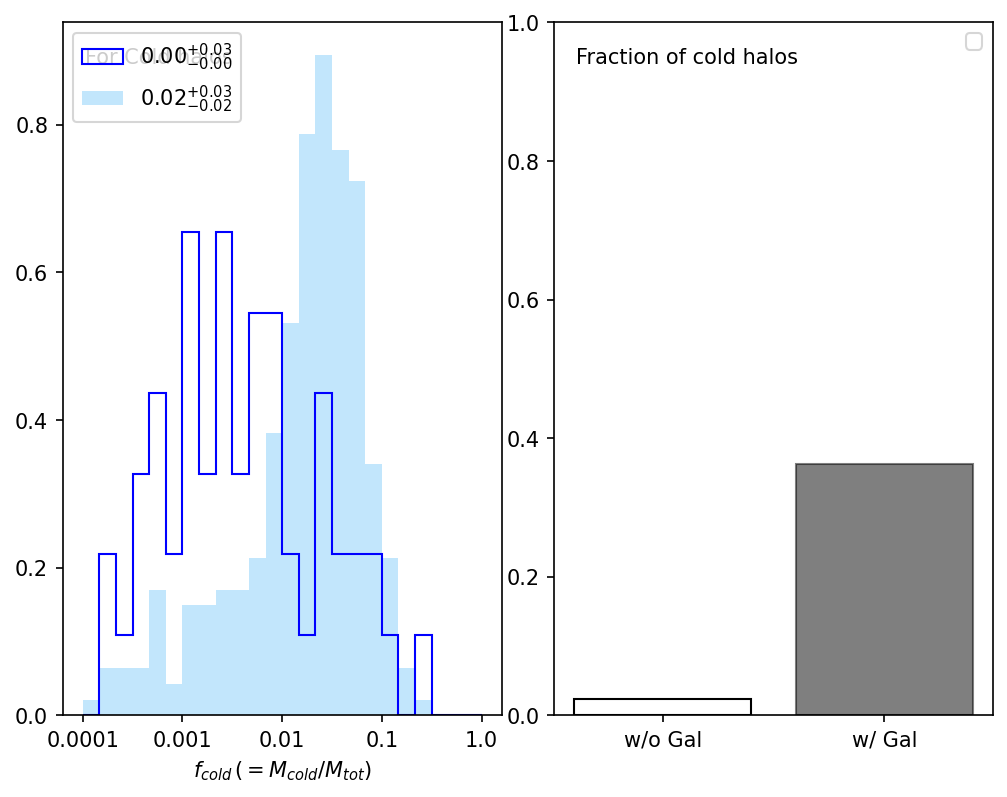

In [126]:
# Mass
fig, axes = plt.subplots(1,2, figsize=(8,6), dpi=150)#, sharey=True)
tick1 = -4; tick2 = 0
bins = np.linspace(tick1, tick2, 25)
ticks = np.arange(tick1, tick2+1, 1)
ticklabels = [f"{10.**i}" for i in ticks]

pops = [dink_colds, dink_poors, pair_colds, pair_poors]
colors = ['blue', 'k', 'lightskyblue', 'k']
alphas = [1, 1, 0.5, 0.5]
histtypes = ['step', 'step', 'bar', 'bar']
fills = [False, False, True, True]
names = ["w/o Gal\nw/ Cold","w/o Gal\nw/o Cold","w/ Gal\nw/ Cold","w/ Gal\nw/o Cold"]

ax = axes[0]
for i in range(4):
    tmp = pops[i]; tmp = tmp[tmp['mcold']>1e3]
    if(len(tmp)==0): continue
    prop = tmp['mcold']/(tmp['mdm']+tmp['mstar']+tmp['mcell']); prop = np.log10(prop)
    # prop = prop[prop>0]
    qs = 10**np.percentile(prop, [16,50,84])
    ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.text(0.05, 0.95, "For Cold halos", ha='left', va='center', transform=ax.transAxes)
ax.set_xlabel(r"$f_{cold}\,(=M_{cold}/M_{tot})$")
ax.legend()

ax = axes[1]
pops = [dinks, pairs]
colors = ['k','k']
alphas = [1, 0.5]
histtypes = ['step','bar']
fills = [False,True]
names = ["w/o Gal","w/ Gal"]
for i in range(2):
    tmp = pops[i]['mcold']# / (pops[i]['mdm']+pops[i]['mstar']+pops[i]['mcell'])
    val = np.sum(tmp>1e3)/len(tmp)
    ax.bar(i,val, fc=colors[i], ec=colors[i], fill=fills[i], alpha=alphas[i])
    # ax.hist(prop, density=True, bins=bins, alpha=alphas[i], histtype=histtypes[i], color=colors[i], label=fr"{qs[1]:.2f}$^{{+{qs[2]-qs[1]:.2f}}}_{{-{qs[1]-qs[0]:.2f}}}$")
# ax.set_xscale('log')
ax.set_ylim(0,1)
ax.set_xticks([0,1])
ax.set_xticklabels(names)
ax.text(0.05, 0.95, "Fraction of cold halos", ha='left', va='center', transform=ax.transAxes)
ax.legend()


plt.subplots_adjust(wspace=0.12)
plt.show()

# Tentative conclusion:  
Cold gas fraction and Mass itself is matter?  
then why?  
Also is there any other effect?
- Temperature
- Local density
- Density Slope